In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


In [4]:
# 📁 Step 3: Load ESC-50 CSV
# ✅ Update these paths with your actual file structure
CSV_PATH = r'C:\Users\nasrr\Desktop\CNN_Farah\Farah\ESC-50-master\ESC-50-master\meta\esc50.csv'
AUDIO_PATH = r'C:\Users\nasrr\Desktop\CNN_Farah\Farah\ESC-50-master\ESC-50-master\audio'


df = pd.read_csv(CSV_PATH)
print(df.head())

            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A


In [5]:
# 🔉 Step 4: Load YAMNet model
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')


In [ ]:
# 🎧 Step 5: Convert audio to embeddings (X) and labels (y)
X = []
y = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    file_path = os.path.join(AUDIO_PATH, row['filename'])
    label = row['target']

    try:
        waveform, sr = librosa.load(file_path, sr=16000, mono=True)
        waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)

        _, embeddings, _ = yamnet_model(waveform)
        mean_embedding = tf.reduce_mean(embeddings, axis=0).numpy()

        X.append(mean_embedding)
        y.append(label)
    except Exception as e:
        print(f"Failed: {file_path} → {e}")

X = np.array(X)
y = np.array(y)

print("✅ Done: ", X.shape, y.shape)


100%|██████████| 2000/2000 [01:07<00:00, 29.44it/s]

✅ Done:  (2000, 1024) (2000,)


In [ ]:
# 🧠 Step 6: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (1600, 1024) Test: (400, 1024)


In [9]:
import torchaudio.transforms as T
import torch

augment = torch.nn.Sequential(
    T.FrequencyMasking(freq_mask_param=10),
    T.TimeMasking(time_mask_param=20)
)


In [16]:
MAX_FRAMES = 100  # We'll fix all embeddings to this length

X_seq = []
y_seq = []

for idx, row in tqdm(df.iterrows(), total=len(df)):
    file_path = os.path.join(AUDIO_PATH, row['filename'])
    label = row['target']

    try:
        waveform, sr = librosa.load(file_path, sr=16000, mono=True)
        waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)

        _, embeddings, _ = yamnet_model(waveform)
        emb_np = embeddings.numpy()  # shape: (frames, 1024)

        # Pad/truncate to MAX_FRAMES
        if emb_np.shape[0] < MAX_FRAMES:
            pad_width = MAX_FRAMES - emb_np.shape[0]
            emb_np = np.pad(emb_np, ((0, pad_width), (0, 0)), mode='constant')
        else:
            emb_np = emb_np[:MAX_FRAMES, :]

        X_seq.append(emb_np)
        y_seq.append(label)

    except Exception as e:
        print(f"Failed: {file_path} → {e}")

X_seq = np.array(X_seq)  # shape: (N, 100, 1024)
y_seq = np.array(y_seq)

100%|██████████| 2000/2000 [00:59<00:00, 33.54it/s]


In [17]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# DataLoaders
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
from torch.utils.data import random_split

val_pct = 0.1
val_size = int(val_pct * len(train_ds))
train_size = len(train_ds) - val_size

train_set, val_set = random_split(train_ds, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)

test_loader = DataLoader(test_ds, batch_size=32)


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class YAMNet1DCNN_Improved(nn.Module):
    def __init__(self, num_classes=50):
        super().__init__()
        self.conv1 = nn.Conv1d(1024, 512, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(512)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(512, 256, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)

        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.75)  # Slightly higher for better regularization
        self.fc = nn.Linear(128, num_classes)

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (B, 100, 1024) → (B, 1024, 100)
        x = self.pool1(F.gelu(self.bn1(self.conv1(x))))
        x = self.pool2(F.gelu(self.bn2(self.conv2(x))))
        x = F.gelu(self.bn3(self.conv3(x)))
        x = self.global_pool(x).squeeze(-1)
        x = self.dropout(x)
        return self.fc(x)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YAMNet1DCNN_Improved().to(device)

In [20]:
import os
import re
import torch
from tqdm import tqdm
from sklearn.metrics import accuracy_score

model_class = YAMNet1DCNN_Improved
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Match all model files like Model_91_25_Epoch58.pt
model_files = [f for f in os.listdir() if f.startswith("Model_") and f.endswith(".pt")]

# Optional: sort by val_acc descending (if filenames use Model_91_88_Epoch58.pt format)
def extract_val_acc(file):
    match = re.search(r'Model_(\d+)_(\d+)', file)
    if match:
        major, minor = match.groups()
        return float(f"{major}.{minor}")
    return 0

model_files.sort(key=extract_val_acc, reverse=True)

results = []

for model_file in model_files:
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_file))
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for xb, yb in tqdm(test_loader, desc=f"Testing {model_file}"):
            xb = xb.to(device)
            preds = model(xb)
            all_preds.extend(preds.argmax(1).cpu().numpy())
            all_labels.extend(yb.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds) * 100
    results.append((model_file, acc))

# Print sorted results
results.sort(key=lambda x: x[1], reverse=True)

print("\n📊 Model Comparison Results:")
for name, acc in results:
    print(f"{name:<35} → Test Accuracy: {acc:.2f}%")


Testing Model_Final.pt: 100%|██████████| 13/13 [00:00<00:00, 19.02it/s]


📊 Model Comparison Results:
Model_Final.pt                      → Test Accuracy: 89.75%


In [21]:
seeds = [40 ,41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
accuracies = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for seed in seeds:
    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=seed
    )

    # Convert to tensors
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    test_ds = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_ds, batch_size=32)

    # Load model
    model = YAMNet1DCNN_Improved().to(device)
    model.load_state_dict(torch.load("Model_Final.pt"))
    model.eval()

    # Test
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for xb, yb in tqdm(test_loader, desc=f"Seed {seed}"):
            xb = xb.to(device)
            preds = model(xb)
            all_preds.extend(preds.argmax(1).cpu().numpy())
            all_labels.extend(yb.numpy())

    acc = accuracy_score(all_labels, all_preds) * 100
    accuracies.append(acc)
    print(f"🎯 Seed {seed} → Test Accuracy: {acc:.2f}%")

# 📊 Final result
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

print(f"\n✅ Averaged Test Accuracy: {mean_acc:.2f}% ± {std_acc:.2f}% over {len(seeds)} seeds")

Seed 40: 100%|██████████| 13/13 [00:00<00:00, 25.09it/s]


🎯 Seed 40 → Test Accuracy: 97.50%


Seed 41: 100%|██████████| 13/13 [00:00<00:00, 25.35it/s]


🎯 Seed 41 → Test Accuracy: 97.00%


Seed 42: 100%|██████████| 13/13 [00:00<00:00, 24.54it/s]


🎯 Seed 42 → Test Accuracy: 89.75%


Seed 43: 100%|██████████| 13/13 [00:00<00:00, 23.43it/s]


🎯 Seed 43 → Test Accuracy: 95.75%


Seed 44: 100%|██████████| 13/13 [00:00<00:00, 25.28it/s]


🎯 Seed 44 → Test Accuracy: 97.00%


Seed 45: 100%|██████████| 13/13 [00:00<00:00, 23.14it/s]


🎯 Seed 45 → Test Accuracy: 97.50%


Seed 46: 100%|██████████| 13/13 [00:00<00:00, 25.48it/s]


🎯 Seed 46 → Test Accuracy: 96.75%


Seed 47: 100%|██████████| 13/13 [00:00<00:00, 23.25it/s]


🎯 Seed 47 → Test Accuracy: 96.00%


Seed 48: 100%|██████████| 13/13 [00:00<00:00, 25.44it/s]


🎯 Seed 48 → Test Accuracy: 97.50%


Seed 49: 100%|██████████| 13/13 [00:00<00:00, 23.42it/s]


🎯 Seed 49 → Test Accuracy: 98.00%


Seed 50: 100%|██████████| 13/13 [00:00<00:00, 25.61it/s]

🎯 Seed 50 → Test Accuracy: 97.00%

✅ Averaged Test Accuracy: 96.34% ± 2.18% over 11 seeds


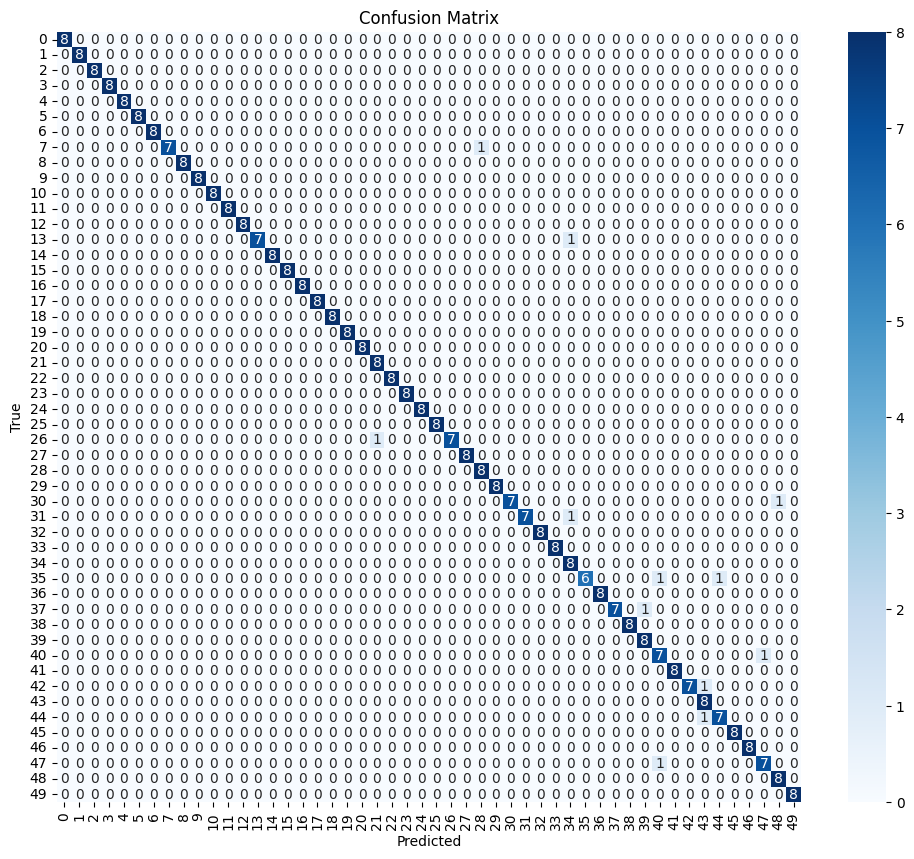

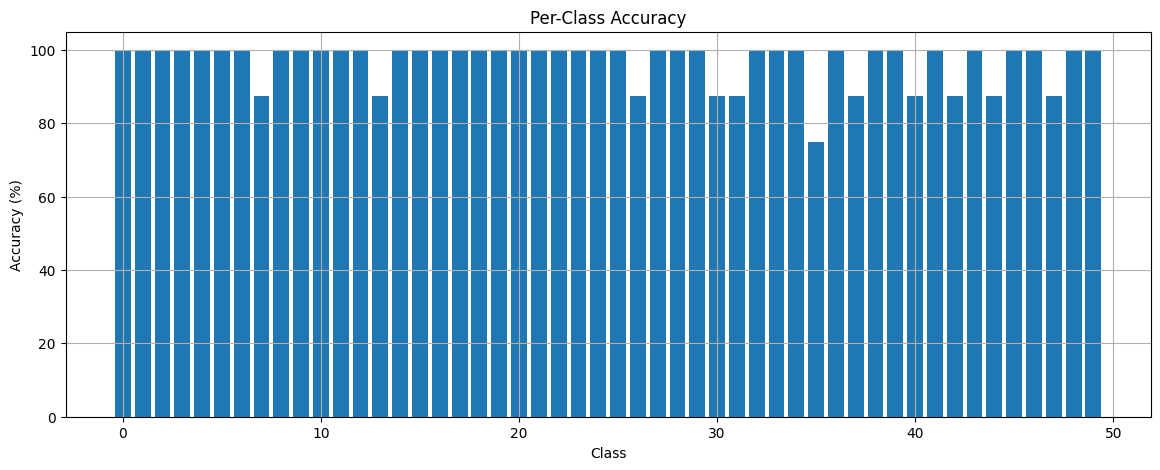

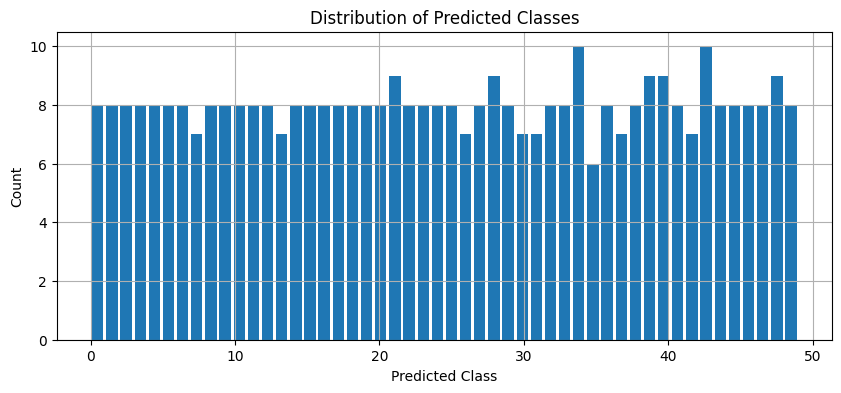

In [23]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

# Get predictions
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb)
        all_preds.extend(preds.argmax(1).cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

# Convert to numpy
y_pred = np.array(all_preds)
y_true = np.array(all_labels)

# 1. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 2. Per-Class Accuracy
class_acc = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(14, 5))
plt.bar(np.arange(len(class_acc)), class_acc * 100)
plt.xlabel("Class")
plt.ylabel("Accuracy (%)")
plt.title("Per-Class Accuracy")
plt.grid(True)
plt.show()

# 3. Prediction Distribution
plt.figure(figsize=(10, 4))
plt.hist(y_pred, bins=len(set(y_true)), rwidth=0.8)
plt.title("Distribution of Predicted Classes")
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.grid(True)
plt.show()


In [32]:
import librosa
import tensorflow_hub as hub


# Constants
MAX_FRAMES = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = YAMNet1DCNN_Improved().to(device)
model.load_state_dict(torch.load("Model_Final.pt"))
model.eval()

# Function to preprocess one .wav file
def preprocess_single_wav(file_path):
    waveform, sr = librosa.load(file_path, sr=16000, mono=True)
    waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)

    _, embeddings, _ = yamnet_model(waveform)
    emb_np = embeddings.numpy()  # shape: (frames, 1024)

    # Pad or truncate to MAX_FRAMES
    if emb_np.shape[0] < MAX_FRAMES:
        pad_width = MAX_FRAMES - emb_np.shape[0]
        emb_np = np.pad(emb_np, ((0, pad_width), (0, 0)), mode='constant')
    else:
        emb_np = emb_np[:MAX_FRAMES, :]

    return emb_np  # shape: (100, 1024)

new_file_path = "Chirping-Birds.wav"

# Preprocess and predict
embedding = preprocess_single_wav(new_file_path)
input_tensor = torch.tensor(embedding, dtype=torch.float32).unsqueeze(0).to(device)  # shape: (1, 100, 1024)

with torch.no_grad():
    output = model(input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()
    
    # Create mapping: {0: 'dog', 1: 'rooster', ..., 49: 'coughing'}
target_to_category = df.drop_duplicates(subset=['target'])[['target', 'category']].sort_values(by='target')
label_map = target_to_category.set_index('target')['category'].to_dict()

predicted_label = label_map[predicted_class]
print(f"Predicted class for '{new_file_path}': {predicted_class} → {predicted_label}")


Predicted class for 'Chirping-Birds.wav': 14 → chirping_birds


In [33]:
new_file_path = "DOG10.wav"

# Preprocess and predict
embedding = preprocess_single_wav(new_file_path)
input_tensor = torch.tensor(embedding, dtype=torch.float32).unsqueeze(0).to(device)  # shape: (1, 100, 1024)

with torch.no_grad():
    output = model(input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()
    
    # Create mapping: {0: 'dog', 1: 'rooster', ..., 49: 'coughing'}
target_to_category = df.drop_duplicates(subset=['target'])[['target', 'category']].sort_values(by='target')
label_map = target_to_category.set_index('target')['category'].to_dict()

predicted_label = label_map[predicted_class]
print(f"Predicted class for '{new_file_path}': {predicted_class} → {predicted_label}")


Predicted class for 'DOG10.wav': 0 → dog


In [34]:
new_file_path = "dog-barking.wav"

# Preprocess and predict
embedding = preprocess_single_wav(new_file_path)
input_tensor = torch.tensor(embedding, dtype=torch.float32).unsqueeze(0).to(device)  # shape: (1, 100, 1024)

with torch.no_grad():
    output = model(input_tensor)
    predicted_class = torch.argmax(output, dim=1).item()
    
    # Create mapping: {0: 'dog', 1: 'rooster', ..., 49: 'coughing'}
target_to_category = df.drop_duplicates(subset=['target'])[['target', 'category']].sort_values(by='target')
label_map = target_to_category.set_index('target')['category'].to_dict()

predicted_label = label_map[predicted_class]
print(f"Predicted class for '{new_file_path}': {predicted_class} → {predicted_label}")


Predicted class for 'dog-barking.wav': 0 → dog
